In [22]:
import cv2
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix
from random import choice,sample
from ipynb.fs.full.create_dataframe import read_data

from sklearn.metrics import roc_curve, auc
from ipynb.fs.full.gen_atlas_data import gen_pairs


In [23]:
def center_crop(im, crop_pixels = 20):
    return im[crop_pixels:im.shape[0] - crop_pixels, 10:im.shape[1] - crop_pixels]

In [24]:
def basic_preprocess(dataframe):
    # Basic preprocessing 
    dataframe=dataframe[dataframe.astype(str)['image'] != '[]']
    # prepare X
    img_list = list(dataframe['image'])
    data_img = []
    for each in img_list:
                each_img = cv2.cvtColor(each, cv2.COLOR_BGR2RGB)
                #Resize the images:
                each_img_resized = cv2.resize(each_img, (128,128))

                each_img_cropped=center_crop(each_img_resized)

        
                #Save arrays to a list:
                data_img.append(each_img_cropped)
    # Converting list to numpy array
    X = np.array(data_img)

    # prepare y
    y = OneHotEncoder(dtype='int8', sparse=False).fit_transform(dataframe['target'].values.reshape(-1,1))

    return X,y

def fit_model(X_train,y_train,X_val,y_val):
    #  code adapted from:
    #  https://pub.towardsai.net/multiclass-image-classification-hands-on-with-keras-and-tensoflow-e1cf434f3467


    train_gen = ImageDataGenerator(horizontal_flip=True,
                               rotation_range = 45,
                               zoom_range=0.2,
                               height_shift_range = 0.5,
                               width_shift_range = 0.5)
    validation_gen = ImageDataGenerator(horizontal_flip=True,
                                    rotation_range = 45,
                                    zoom_range=0.2,
                                    height_shift_range = 0.5,
                                    width_shift_range = 0.5)
    train_gen.fit(X_train)
    validation_gen.fit(X_val)
    batch_size = 64
    epochs = 10
    base = Xception(include_top=False, 
                weights='imagenet', 
                input_shape=X_train[1].shape)
    x = base.output
    x = GlobalAveragePooling2D()(x)
    head = Dense(y_train.shape[1], activation='softmax')(x)
    model = Model(inputs=base.input, outputs=head)
    model.compile(optimizer=Adam(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'], run_eagerly=True)
    
    fit = model.fit_generator(
               train_gen.flow(X_train, y_train,
               batch_size=batch_size),
               epochs = epochs,
               validation_data = validation_gen.flow(X_val, y_val)
)

    return model,fit


In [25]:
# create dataframe using other file's code
reptiles=read_data(["Crocodile_Alligator","Gecko"])
pair_data=gen_pairs(2800,reptiles)
reptiles=pair_data

reptiles.target.value_counts()

Turtle_Tortoise    594
Frog_Toad          574
Lizard             556
Salamander         546
Snake              530
Name: target, dtype: int64

In [26]:
reptiles

,image,target
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",Salamander
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",Turtle_Tortoise
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",Frog_Toad
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",Salamander
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",Salamander
...,...,...
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",Turtle_Tortoise
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",Snake
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",Lizard
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",Turtle_Tortoise


In [27]:
#reptiles['image']=reptiles['image'].apply(lambda x: center_crop(x))

In [28]:
X,y= basic_preprocess(reptiles) ## replace this to change preprocessing

X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_val shape  : ', X_val.shape)
print('y_val shape  : ', y_val.shape)
print('X_test shape : ', X_test.shape)
print('y_test shape : ', y_test.shape)

X_train shape:  (1904, 88, 98, 3)
y_train shape:  (1904, 5)
X_val shape  :  (476, 88, 98, 3)
y_val shape  :  (476, 5)
X_test shape :  (420, 88, 98, 3)
y_test shape :  (420, 5)


In [29]:
X[1].shape


(88, 98, 3)

In [30]:
model,fit=fit_model(X_train,y_train,X_val,y_val)

/var/folders/5b/sjkc4b8n0hs41zd03hxr66100000gn/T/ipykernel_4539/661476147.py:55: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit = model.fit_generator(


Epoch 1/10
30/30 [==============================] - 210s 7s/step - loss: 1.6006 - accuracy: 0.2521 - val_loss: 1.7681 - val_accuracy: 0.2227
Epoch 2/10
30/30 [==============================] - 207s 7s/step - loss: 1.4929 - accuracy: 0.3498 - val_loss: 1.5022 - val_accuracy: 0.3172
Epoch 3/10
30/30 [==============================] - 207s 7s/step - loss: 1.3758 - accuracy: 0.4175 - val_loss: 1.4262 - val_accuracy: 0.3887
Epoch 4/10
30/30 [==============================] - 208s 7s/step - loss: 1.2673 - accuracy: 0.4874 - val_loss: 1.3557 - val_accuracy: 0.4433
Epoch 5/10
30/30 [==============================] - 206s 7s/step - loss: 1.1789 - accuracy: 0.5378 - val_loss: 1.3710 - val_accuracy: 0.4832
Epoch 6/10
30/30 [==============================] - 206s 7s/step - loss: 1.0972 - accuracy: 0.5762 - val_loss: 1.2414 - val_accuracy: 0.5315
Epoch 7/10
30/30 [==============================] - 209s 7s/step - loss: 1.0411 - accuracy: 0.5898 - val_loss: 1.1973 - val_accuracy: 0.5315
Epoch 8/10
30

14/14 [==============================] - 10s 683ms/step


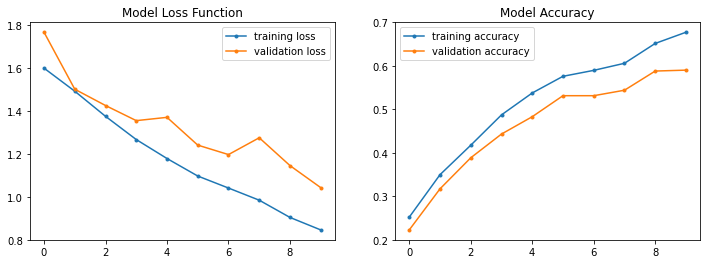

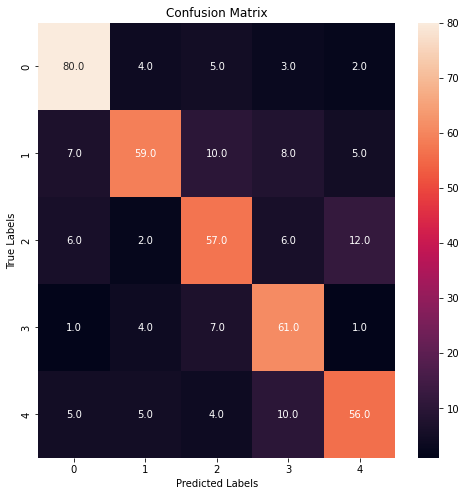

In [31]:
def make_plots(model_fit):
    history_df = pd.DataFrame(model_fit.history)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history_df['loss'], '.', linestyle='solid', label='training loss')
    plt.plot(history_df['val_loss'], '.', linestyle='solid', label='validation loss')
    plt.title('Model Loss Function')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history_df['accuracy'], '.', linestyle='solid', label='training accuracy')
    plt.plot(history_df['val_accuracy'], '.', linestyle='solid', label='validation accuracy')
    plt.title('Model Accuracy')
    plt.legend();

def getPredTestClasses(model, X_test):
    y_pred = model.predict(X_test)
    # Converting prediction classes from one hot encoding to list
    # Argmax returns the position of the largest value
    y_pred_classes = np.argmax(y_pred, axis = 1)
    # Convert test labels from one hot encoding to list
    y_test_classes = np.argmax(y_test, axis = 1)
    return y_test_classes,y_pred_classes

def make_conf_matrix(y_test_classes,y_pred_classes):
    # Create the confusion matrix
    confmx = confusion_matrix(y_test_classes, y_pred_classes)
    f, ax = plt.subplots(figsize = (8,8))
    sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show();

make_plots(fit)
y_test_classes,y_pred_classes= getPredTestClasses(model, X_test)
make_conf_matrix(y_test_classes,y_pred_classes)

In [32]:
def create_label_key(y,data):
    dic={}
    for s in np.arange(0, len(reptiles), 520, dtype=int):
        key_value=data["target"][s]
        key=np.where(y[s] == 1)[0][0]
        dic[key]=key_value
    return dic

predicted=pd.DataFrame({"True":y_test_classes,"Pred":y_pred_classes})

# change classes to actual labels
label_key = create_label_key(y,reptiles)
predicted=predicted.replace({"True": label_key,"Pred":label_key})

KeyError: 520

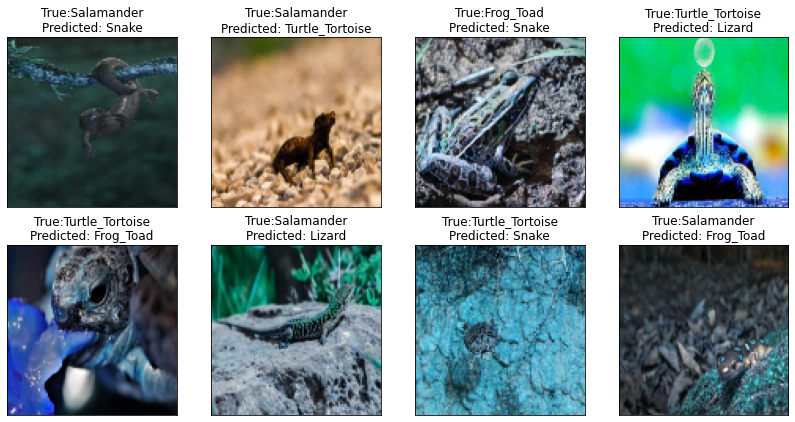

In [ ]:
def show_sample_misclassified(predicted):
    misclassified=predicted.loc[~(predicted['True'] == predicted['Pred'])]
    indices = sample(misclassified.index.to_list(),8)
    i = 1
    plt.figure(figsize=(14,7))
    for each in indices:
        plt.subplot(2,4,i)
        plt.imshow(Image.fromarray(X_test[each]))
        plt.title("True:"+str(misclassified['True'].loc[each])+"\nPredicted: "+str(misclassified['Pred'].loc[each]))
        plt.xticks([])
        plt.yticks([])
        i += 1

show_sample_misclassified(predicted)

12/12 [==============================] - 11s 881ms/step


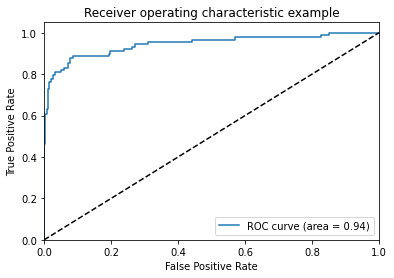

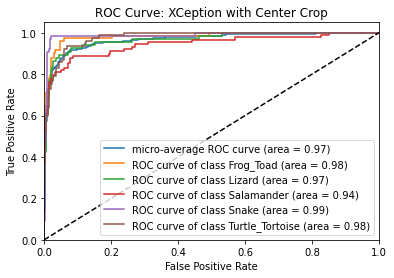

In [ ]:
n_classes=reptiles["target"].nunique()
y_score=model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(label_key.get(i), roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: XCeption with Center Crop, Paired Images')
plt.legend(loc="lower right")
plt.show()